# Spectroscopic Trace tutorial

This tutorial will walk through the derivation of a spectroscopic trace model and extraction using astropy tools.

A spectroscopic trace is the path of a point source (star) spectrum through a two-dimensional dispersed spectrum.  The trace is needed because, in general, spectra are not perfectly aligned with the axes of a detector.

# Step 1: Examine the spectrum

We'll work with a 2D spectrum that contains *no* attached metadata, so we have to infer many of the features ourselves.

All we know is that this is a spectrum of a star, Aldebaran.

Our data are, strangely, in the form of .bmp (bitmap) files, so we need PIL (Python Imaging Library) to open them.

In [32]:
from PIL import Image
import numpy as np
from astropy.io import fits
import glob

In [33]:
spectrum_filename = 'sun_100ms001_AST4723C_class.FIT'

In [34]:
image_data = (np.mean([fits.getdata(x) for x in glob.glob('sun_100ms00*_AST4723C_class.FIT')],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob('dark_1e-1s00*_AST4723C_class.FIT')],
                        axis=0)
             )

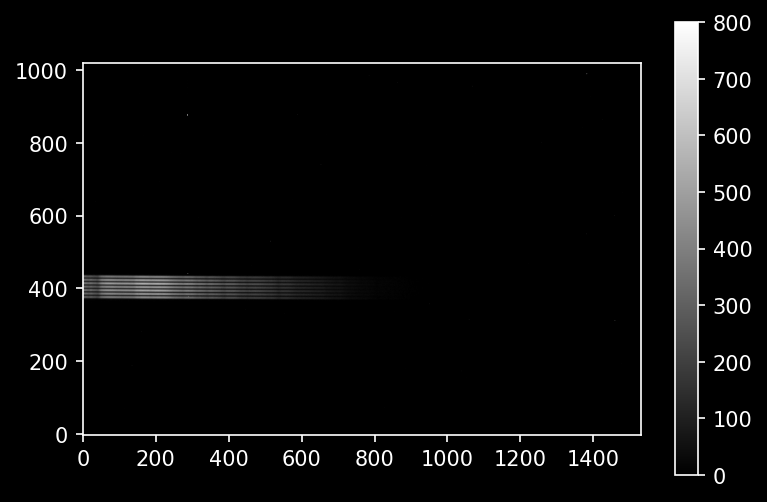

In [35]:
%matplotlib inline
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.dpi'] = 150
pl.matplotlib.style.use('dark_background') # Optional!
pl.imshow(image_data, cmap='gray', vmax=0, vmin=800)
pl.colorbar()

The main goal of the trace is to obtain a two-dimensional model `f(x)` defining the position of the light along the detector.

We're going to start by assuming that wavelength dispersion is in the X-direction and the Y-direction is entirely spatial.  This is an approximation, but evidently (by looking at the image), it's a decent one.

# Step 1b. Extract a single spectrum to further trace

We can't follow the same process as before because we now have 7 spectra.  We need to trace each of them

We do this by finding linear cuts between the spectra.  This is easiest to do by drawing a line in ds9 and calculating its slope:

In [36]:
# I drew a line between the top two spectra
dy = -3.7
dx = 871
slope = dy/dx

In [37]:
ystart = 365
yend = 441

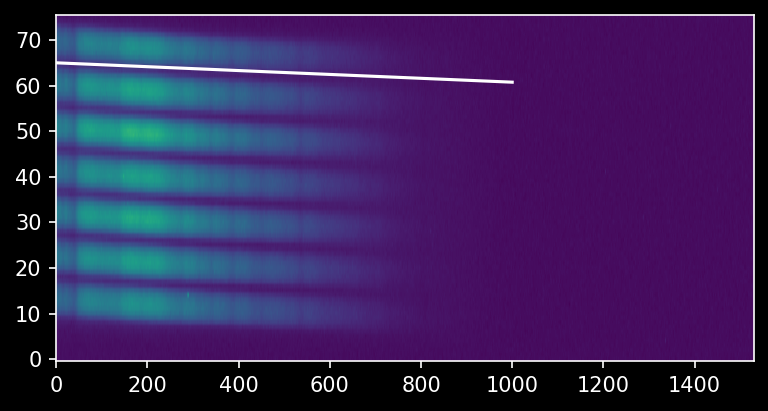

In [38]:
image_array = np.array(image_data)
image_array = image_array - np.median(image_array)
pl.imshow(image_array[ystart:yend,:])
pl.plot([0,1000], 65 + np.array([0,1000]) * slope, color='w')
pl.gca().set_aspect(10)

We can repeat this every _n_ pixels:

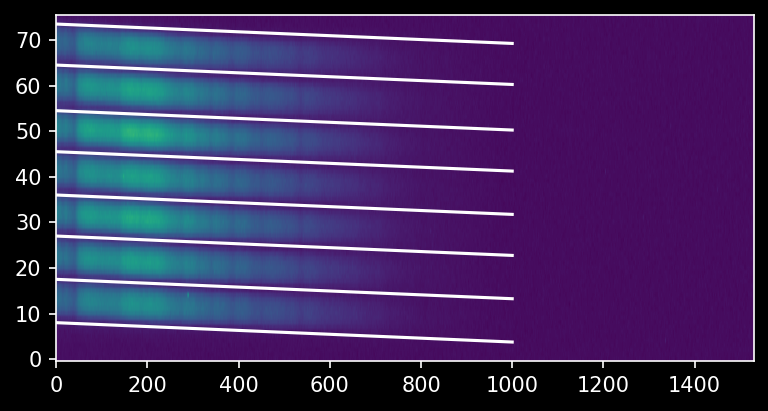

In [39]:
intertrace_cuts = np.array([ 8, 17.5, 27, 36, 45.5, 54.5, 64.5, 73.5])
image_array = np.array(image_data)
image_array = image_array - np.median(image_array)
pl.imshow(image_array[ystart:yend,:])
pl.plot([0,1000], intertrace_cuts + np.array([0,1000])[:,None] * slope, color='w')
pl.gca().set_aspect(10)

We're then going to use the technique from Step 4 below to cut these out:

In [40]:
npixels_to_cut = 4 # very conservative - we'll see why below
xvals = np.arange(image_array.shape[1])
trace_center = ystart+(intertrace_cuts[0] + intertrace_cuts[1])/2 + xvals * slope
cutout_trace = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)]).T
cutout_trace.shape

(8, 1530)

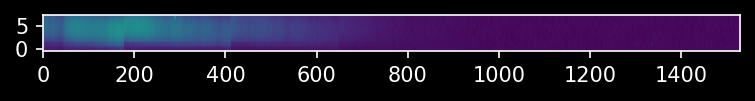

In [41]:
pl.imshow(cutout_trace)
pl.gca().set_aspect(10);

We can now proceed with this somewhat awkward cutout.

# Step 2: Use moment analysis to extract a spine to trace

We can use moments to get measurements of all the data.

Note that we need to subtract off the background to avoid a bias toward the center, so we use the median of the image as our background estimate.

In [42]:
# to get the y-axis values corresponding to each part of our cutout trace, we do the same operation we did on the image
yaxis_full = np.arange(image_array.shape[0])
yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                    for yval, ii in zip(trace_center, xvals)]).T

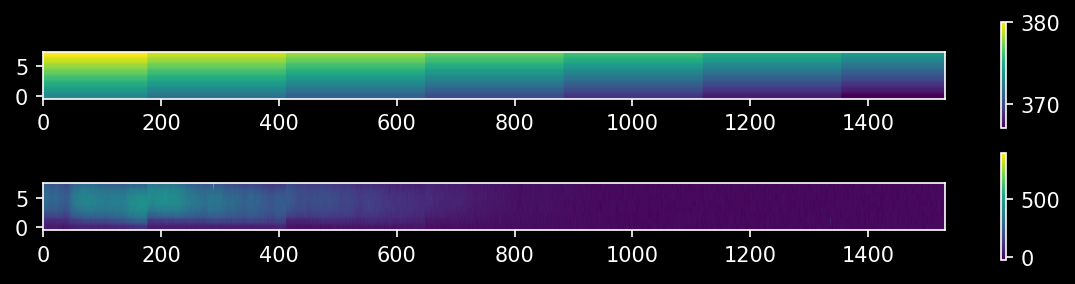

In [43]:
pl.figure(figsize=(8,2))
im = pl.subplot(2,1,1).imshow(yaxis)
pl.colorbar(mappable=im)
pl.gca().set_aspect(10);
im = pl.subplot(2,1,2).imshow(cutout_trace)
pl.colorbar(mappable=im)
pl.gca().set_aspect(10);
pl.tight_layout();

Plot the sum of the trace to see where it cuts off (if the trace sums to zero, it's no good - average will break)

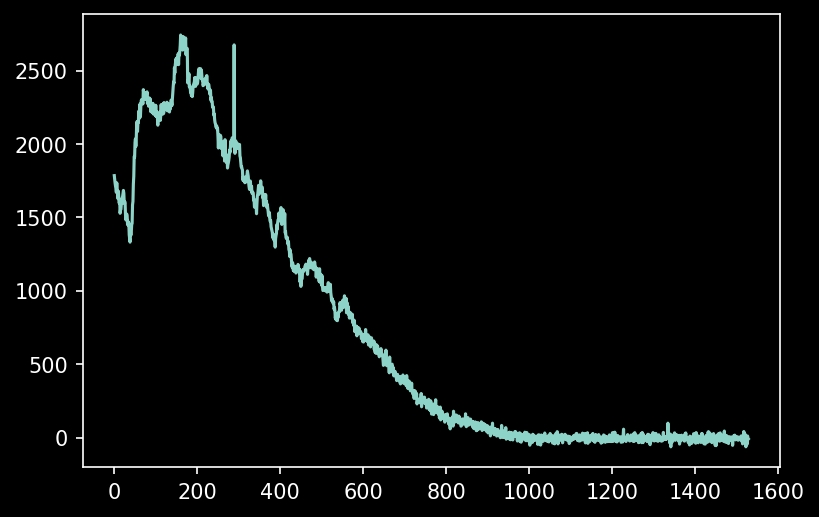

In [44]:
pl.plot(cutout_trace.sum(axis=0))

We slim down the cutout to just the zone with significant detections

In [45]:
# moment 1 is the data-weighted average of the Y-axis coordinates
xend = 800
weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])

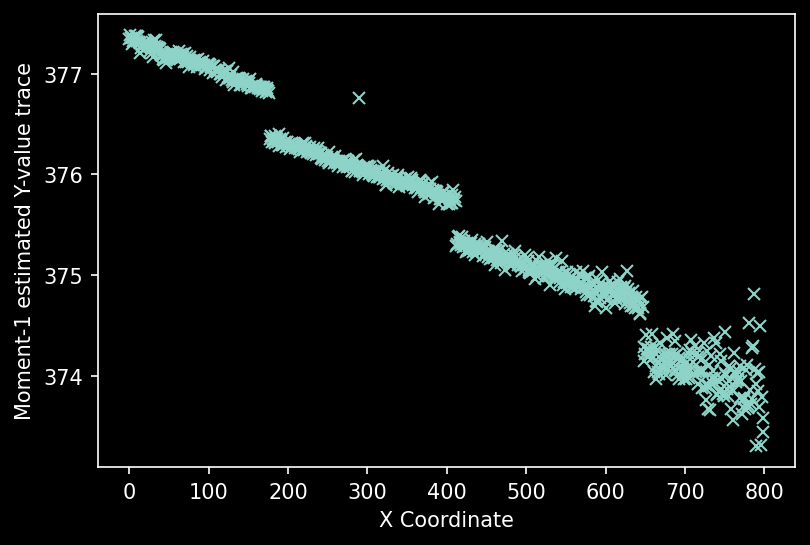

In [46]:
_=pl.plot(xvals[:xend], weighted_yaxis_values, 'x')
_=pl.xlabel("X Coordinate")
_=pl.ylabel("Moment-1 estimated Y-value trace")

Overplot the "weighted", centroid locations on the data to verify they look reasonable.

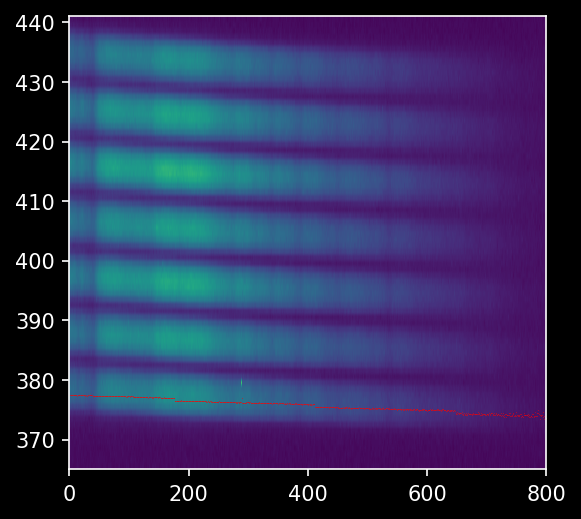

In [47]:
# we need to use the 'extent' keyword to have the axes correctly labeled
_=pl.imshow(image_array[ystart:yend, :xend],
            extent=[0,xend,ystart,yend],
           )
_=pl.gca().set_aspect(10) # we stretch the image out by 10x in the y-direction
_=pl.plot(xvals[:xend], weighted_yaxis_values[:xend], 'r,', alpha=0.5)
_=pl.axis((0,xend,ystart,yend))

We can repeat this for each:

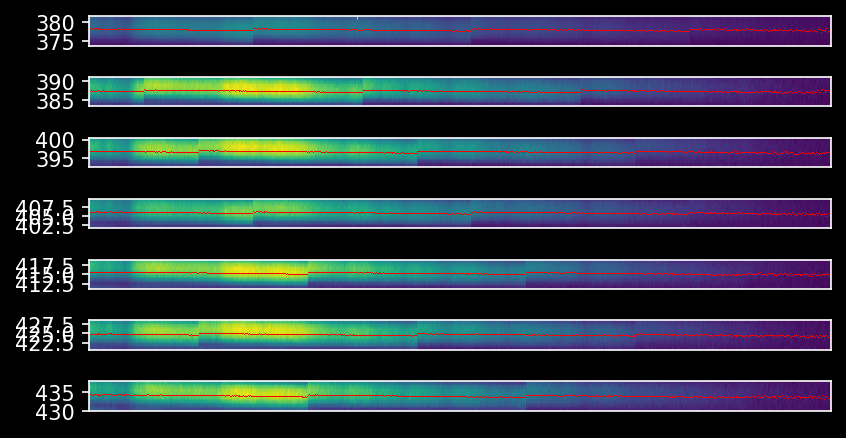

In [48]:
pl.figure(figsize=(8,3))
traces = {}
for trace_index in range(len(intertrace_cuts)-1):
    yoffset = ystart + (intertrace_cuts[trace_index] + intertrace_cuts[trace_index+1])/2
    trace_center = yoffset + slope * xvals

    cutout_trace = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                        for yval, ii in zip(trace_center, xvals)]).T
    yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                     for yval, ii in zip(trace_center, xvals)]).T
    weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
    
    # it takes a little mental gymnastics to get to this, but: to show the trace properly on our cutout,
    # we need to calculate the local version
    local_weighted_yaxis_values = np.average(np.arange(npixels_to_cut*2)[:,None] * np.ones(xend)[None,:],
                                             axis=0, weights=cutout_trace[:,:xend])
    
    traces[trace_index] = weighted_yaxis_values
    ax = pl.subplot(7, 1, trace_index+1)
    ax.imshow(cutout_trace[:,:xend], extent=[0, xend, yoffset-npixels_to_cut, yoffset + npixels_to_cut])
    ax.plot(xvals[:xend], yoffset - npixels_to_cut + local_weighted_yaxis_values[:xend], 'r,')
    ax.set_aspect(4)
    ax.set_xticks([])
pl.tight_layout()

#  IMPORTANT aside: 
What happens if `npixels_to_cut` is too big?

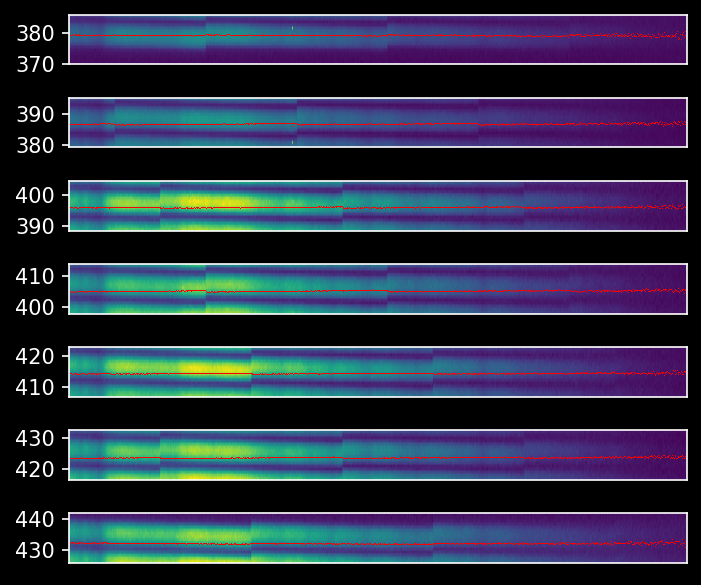

In [49]:
npixels_to_cut_good = npixels_to_cut
npixels_to_cut = 8

for trace_index in range(len(intertrace_cuts)-1):
    yoffset = ystart + (intertrace_cuts[trace_index] + intertrace_cuts[trace_index+1])/2
    trace_center = yoffset + slope * xvals

    cutout_trace = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                        for yval, ii in zip(trace_center, xvals)]).T
    yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                     for yval, ii in zip(trace_center, xvals)]).T
    weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
    

    local_weighted_yaxis_values = np.average(np.arange(npixels_to_cut*2)[:,None] * np.ones(xend)[None,:],
                                             axis=0, weights=cutout_trace[:,:xend])
    
    ax = pl.subplot(7, 1, trace_index+1)
    ax.imshow(cutout_trace[:,:xend], extent=[0, xend, yoffset-npixels_to_cut, yoffset + npixels_to_cut])
    ax.plot(xvals[:xend], yoffset - npixels_to_cut + local_weighted_yaxis_values[:xend], 'r,')
    ax.set_aspect(4)
    ax.set_xticks([])
pl.tight_layout()
npixels_to_cut = npixels_to_cut_good

(0.0, 800.0, 365.0, 441.0)

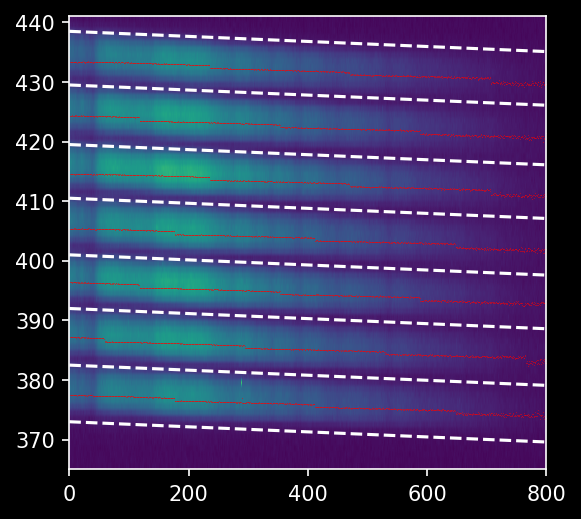

In [50]:
# then we can plot the "global" version here
pl.imshow(image_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for trace in traces.values():
    pl.plot(xvals[:xend], trace[:xend], 'r,', alpha=0.5)
pl.axis((0,xend,ystart,yend))

# Step 3. Fit the trace profile

We want a model `f(x)` that gives the y-value of the centroid as a function of x.

In [51]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

In [52]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

In [53]:
fitted_polymodels

{0: <Polynomial1D(2, c0=377.43055286, c1=-0.00458145, c2=-0.)>,
 1: <Polynomial1D(2, c0=386.86790899, c1=-0.00495945, c2=0.00000048)>,
 2: <Polynomial1D(2, c0=396.26192876, c1=-0.00529218, c2=0.00000074)>,
 3: <Polynomial1D(2, c0=405.35739785, c1=-0.00420823, c2=-0.00000079)>,
 4: <Polynomial1D(2, c0=414.53867029, c1=-0.00315287, c2=-0.00000205)>,
 5: <Polynomial1D(2, c0=424.260403, c1=-0.00518451, c2=0.00000041)>,
 6: <Polynomial1D(2, c0=433.38069598, c1=-0.00361686, c2=-0.00000155)>}

(0.0, 800.0, 365.0, 441.0)

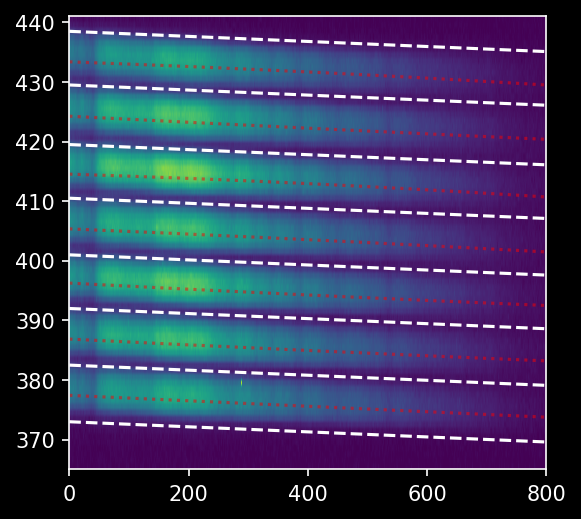

In [54]:
pl.imshow(image_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=700,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

# Step 4. Obtain the trace profile

In [55]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)

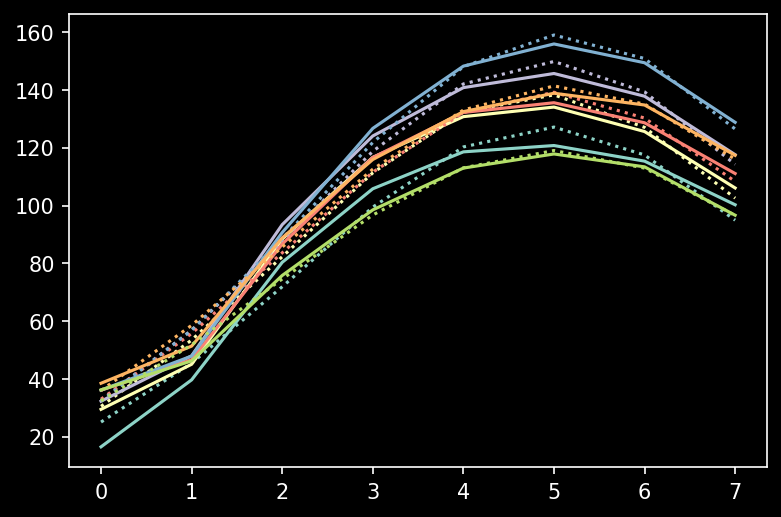

In [56]:
npixels_to_cut_trace = 4

for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([image_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    line, = pl.plot(trace_profile, label=trace_index)
    pl.plot(trace_profile_xaxis, model_trace_profile, color=line.get_color(), linestyle=':')

Now we want to fit that profile with a Gaussian, so we import the Gaussian model profile and non-linear fitter and run a fit:

# Step 5. Extract the traced spectra

In [57]:
spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([image_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    spectra[trace_index] = trace_avg_spectrum

(0.0, 800.0)

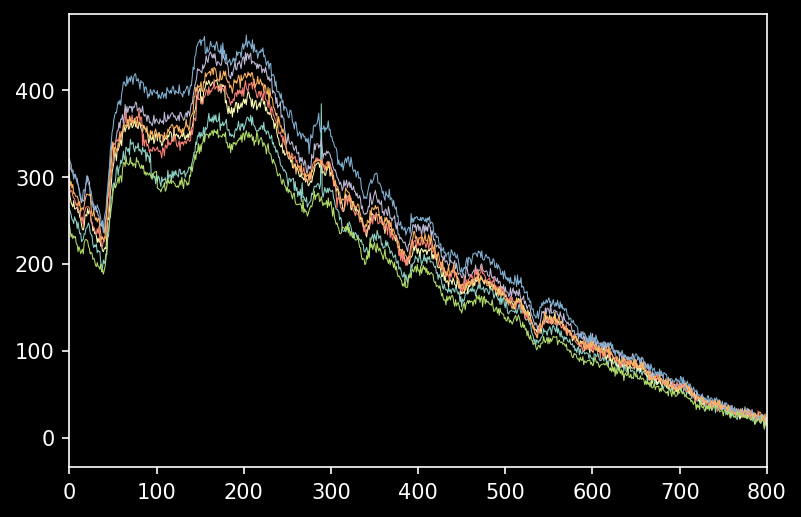

In [58]:
for index in spectra:
    pl.plot(spectra[index], linewidth=0.5)
pl.xlim(0,800)

In general, the trace-weighted average will have higher signal-to-noise.

# Step 6: Repeat for another file

In [59]:
image_data2 = (np.mean([fits.getdata(x) for x in glob.glob('H_5s*_AST4723C_class.FIT')],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob('dark_1e0s00*_AST4723C_class.FIT')],
                        axis=0)
             )
image_array2 = image_data2

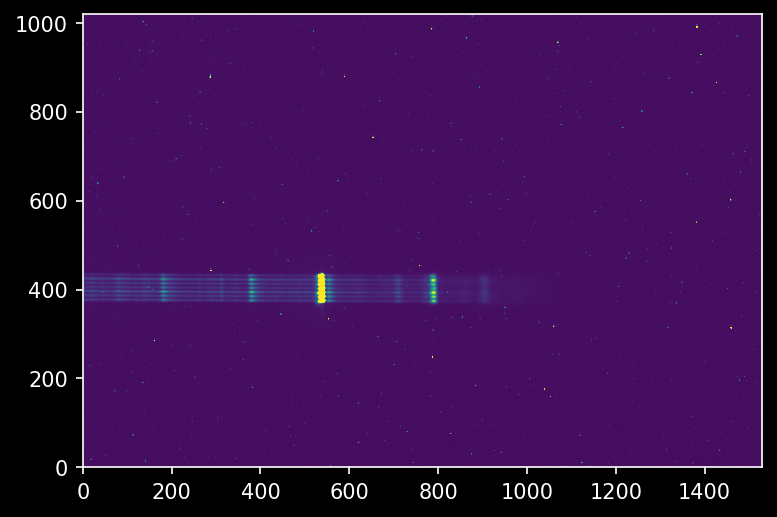

In [60]:
pl.imshow(image_data2, vmax=1000)

In [61]:
spectra2 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    spectra2[trace_index] = trace_avg_spectrum

(0.0, 800.0)

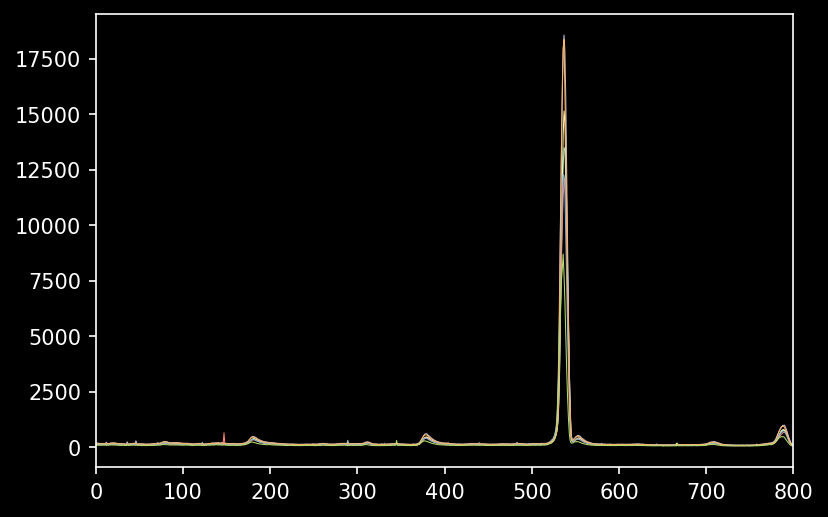

In [62]:
for index in spectra2:
    pl.plot(spectra2[index], linewidth=0.5)
pl.xlim(0,800)